# compute spectra on mitgcm outputs

---

In [1]:
import os

from matplotlib import pyplot as plt
%matplotlib inline

import xrft

#from utils import *

In [2]:

# utils.py

# for some reason the code hangs if I place this in utils.py and try to import it

import os

import numpy as np
import dask
import xarray as xr

import xmitgcm as xm

def get_compressed_level_index(grid_dir, index_fname='llc4320_compressed_level_index.nc', geometry='llc'):
    ''' Some doc
    '''
    #
    ds = xm.open_mdsdataset('', grid_dir=grid_dir,
                             iters=None, geometry=geometry, read_grid=True,
                             default_dtype=np.dtype('>f4'),
                             ignore_unknown_vars=True)
    
    # get shape
    #nz, nface, ny, nx = ds.hFacC.shape
    #shape = (1, nface, ny, nx)
    
    try:
        ds_index = xr.open_dataset(grid_dir+index_fname)
    except OSError:
        # compute and save mask indices
        print('Create llc4320_compressed_level_index.nc in grid_dir')
        ds_index = ((ds.reset_coords()[['hFacC', 'hFacW','hFacS']] > 0).sum(axis=(1, 2, 3)))
        ds_index.coords['k'] = ds.k
        ds_index.load().to_netcdf(grid_dir+index_fname)
        print('done')

    return ds_index, ds
    

def load_level_from_3D_field(data_dir, varname, inum, offset, count, mask, dtype):
    ''' Some doc
    '''

    inum_str = '%010d' % inum
    # all iters in one directory:
    fname = os.path.join(data_dir, '%s.%s.data.shrunk' % (varname, inum_str))
    
    with open(fname, mode='rb') as file:
        file.seek(offset * dtype.itemsize)
        data = np.fromfile(file, dtype=dtype, count=count)
    
    data_blank = np.full_like(mask, np.nan, dtype='f4')
    data_blank[mask] = data
    data_blank.shape = mask.shape
    data_llc = xm.utils._reshape_llc_data(data_blank, jdim=0).compute(get=dask.get)
    data_llc.shape = (1,) + data_llc.shape
    return data_llc


def lazily_load_level_from_3D_field(data_dir, varname, inum, offset, count, mask, shape, dtype):
    ''' Some doc
    '''
    return dask.array.from_delayed(dask.delayed(load_level_from_3D_field)
                            (data_dir, varname, inum, offset, count, mask, dtype),
                            shape, dtype)


def get_compressed_data(varname, data_dir, grid_dir, ds_index=None, ds=None, iters='all', 
                        time=None, client=None, k=0, point='C', **kwargs):
    ''' Get mitgcm compressed data
    
    Parameters
    ----------
    varname: string
        Variable name to load (should allow for list?)
    data_dir: string
        Path to the directory where the mds .data and .meta files are stored
    grid_dir: string
        Path to the directory where grid files are stored
    ds_index: xarray Dataset, optional
        Contains compressed file
    iters: list, 'all', optional
        The iterations numbers of the files to be read. If 'all' (default), all iterations 
        will be read.
    k: int
        vertical level loaded
    point: string
        grid point used for the mask
    '''
    dtype = np.dtype('>f4')
    
    if ds_index is None or shape is None or ds is None:
        ds_index, ds = get_compressed_level_index(grid_dir, **kwargs)
        # get shape
        nz, nface, ny, nx = ds.hFacC.shape
        shape = (1, nface, ny, nx)        
        
    strides = [0,] + list(ds_index['hFac' + point].data)
    offset = strides[k]
    count = strides[k+1]
    
    if iters is 'all':
        iters = xm.mds_store._get_all_iternums(data_dir, file_prefixes=varname, file_format='*.??????????.data.shrunk')
    
    # load mask from raw data
    hfac = xm.utils.read_mds(grid_dir + 'hFac' + point,
                            use_mmap=True, dask_delayed=False, force_dict=False)
    mask = hfac[k]>0
    if client is None:
        mask_future = mask
    else:
        mask_future = client.scatter(mask)
    
    data = dask.array.concatenate([lazily_load_level_from_3D_field
                            (data_dir, varname, i, offset, count, mask_future, shape, dtype)
                            for i in iters], axis=0)

    ds[varname] = xr.Variable(['time', 'face', 'j', 'i'], data)   
    if time is not None:
        ds['time'] = time.sel(iters=iters).values
    
    return ds


def get_iters_time(varname, data_dir, delta_t=25.):
    ''' get iteration numbers and derives corresponding time
    Parameters
    ----------
    varname: string
        Variable name to load (should allow for list?)
    data_dir: string
        Path to the directory where the mds .data and .meta files are stored
    delta_t: float
        Model time step
    
    Returns
    -------
    iters: xarray DataArray
        iteration numbers indexed by time
    time: xarray DataArray
        time in seconds
    '''
    iters = xm.mds_store._get_all_iternums(data_dir, file_prefixes=varname, file_format='*.??????????.data.shrunk')
    time = delta_t * np.array(iters)
    
    iters = xr.DataArray(iters, coords=[time], dims=['time'])
    time = xr.DataArray(time, coords=[iters.values], dims=['iters'])
    
    return iters, time
    

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
distributed.client - ERROR - Restart timed out after 5.000000 seconds


Client Scheduler: tcp://10.148.1.31:8786 Dashboard: http://10.148.1.31:8787,Cluster Workers: 118 Cores: 472 Memory: 1180.00 GB


In [4]:

data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

#ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters.isel(time=slice(0,10)), time=time, client=client)
ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))


/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.1-py3.6.egg/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.1-py3.6.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.1-py3.6.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 4096)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

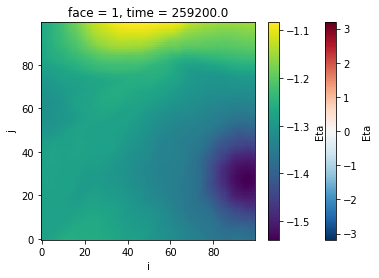

In [ ]:
ds['Eta'].isel(face=1, time=0).plot()
ds['Eta'].isel(face=1, time=0, i=slice(0,100), j=slice(0,100)).plot()

In [ ]:
ds['Eta'].isel(face=1, i=0, j=0).plot()

In [ ]:
ds['Eta'].isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()

---

# spectral computations 

In [ ]:
chunks={'time': len(time), 'face':1,  'i': 10, 'j': 10}
%time ds = ds.chunk(chunks)

In [ ]:
ds

In [ ]:
v_fft = xrft.dft(ds['eta'].isel(face=1).fillna(0.), dim=['time_counter'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0.,drop=False).mean(dim=('i','j'))
E = E.astype('f8').rename('eta_power_spectrum ()')

In [ ]:
%time E.load();

In [ ]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E.plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
#ax.set_ylim([1e-1,1e5])